# Foot Traffic using demo2_NBeats

[PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting) is a package/repository that provides convenient implementations of several leading deep learning-based forecasting models, namely [Temporal Fusion Transformers](https://arxiv.org/pdf/1912.09363.pdf), [N-BEATS](http://arxiv.org/abs/1905.10437), and [DeepAR](https://www.sciencedirect.com/science/article/pii/S0169207019301888). PyTorch Forecasting is built using [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/), making it easier to train in multi-GPU compute environments, out-of-the-box. 

**Note for Colab users:** Run the following cell to install PyTorch Forecasting. After installation completes, you will likely need to restart the Colab runtime. If this is the case, a button `RESTART RUNTIME` will appear at the bottom of the next cell's output.

In [1]:
# !pip install --upgrade google-cloud-bigquery
# !pip install --upgrade google-cloud-storage
# !pip install google-cloud-bigquery-storage
# !pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'

In [2]:
from google.cloud import storage, bigquery
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [3]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-forecasting

In [4]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, Callback
from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline, DeepAR, GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import MAPE, MAE, MASE, RMSE
from pytorch_forecasting.metrics import NormalDistributionLoss

In [5]:
class EpochCallback(Callback):
        
    def on_validation_epoch_end(self, trainer, module):
        print(trainer.progress_bar_metrics)

In [6]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

## Data Loading from BQ

Join 2018 up to 2021

In [7]:
client = bigquery.Client()

def get_query_year(year):
    return f'''SELECT dt.DY_DT, agg.*, store.ENTERPRISE_CD, store.CITY, store.PROV_CD 
        FROM `lt-adp-exp-hdps.VECTOR_TIMESERIES.TXN_{year}_STORE_AGG` as agg
        left join `lt-adp-exp-hdps.REFERENCE_DB.TM_DY` as dt 
            on dt.DY_ID = agg.DY_ID
        left join `lt-adp-exp-hdps.REFERENCE_DB.STORE_INFO` as store
            on store.STORE_IP_ID = agg.STORE_IP_ID
        '''

In [8]:
# %%bigquery data_df_2019
# SELECT dt.DY_DT, agg_2019.*, store.ENTERPRISE_CD, store.CITY, store.PROV_CD 

# FROM `lt-adp-exp-hdps.VECTOR_TIMESERIES.TXN_2019_STORE_AGG` as agg_2019
# left join `lt-adp-exp-hdps.REFERENCE_DB.TM_DY` as dt 
#     on dt.DY_ID = agg_2019.DY_ID
# left join `lt-adp-exp-hdps.REFERENCE_DB.STORE_INFO` as store
#     on store.STORE_IP_ID = agg_2019.STORE_IP_ID

In [9]:
data_df_dict = {}

for year in ['2018', '2019', '2020', '2021']:
    data_df_dict[year] = client.query(get_query_year(year)).to_dataframe()
    print(year, data_df_dict[year].shape[0])

data_df_all = pd.concat(list(data_df_dict.values()))
print(f'\nAll data shape: {data_df_all.shape}')
data_df_all.head()

2018 648590
2019 650140
2020 654513
2021 652272

All data shape: (2605515, 15)


,DY_DT,DY_ID,STORE_IP_ID,FOOT_TRAFFIC,DB_TRAFFIC,HT_TRAFFIC,DL_TRAFFIC,AGE_UNDER_18_TRAFFIC,AGE_18_TO_24_TRAFFIC,AGE_25_TO_44_TRAFFIC,AGE_45_TO_64_TRAFFIC,AGE_65_PLUS_TRAFFIC,ENTERPRISE_CD,CITY,PROV_CD
0,2018-01-01 00:00:00+00:00,2018001,68002,68,7,9,9,3,0,6,14,15,SDM,MONTREAL,QC
1,2018-01-01 00:00:00+00:00,2018001,68003,51,4,3,3,0,1,8,8,3,SDM,GATINEAU,QC
2,2018-01-01 00:00:00+00:00,2018001,68004,48,10,16,19,0,0,4,10,10,SDM,MONTREAL,QC
3,2018-01-01 00:00:00+00:00,2018001,68007,123,21,47,41,7,0,9,23,42,SDM,ST-JEAN-SUR-RICHELIEU,QC
4,2018-01-01 00:00:00+00:00,2018001,68008,158,24,61,54,4,3,10,18,82,SDM,COTE ST-LUC,QC


## preprocess Data

In [10]:
data_df = data_df_all.copy()
data_df.columns

Index(['DY_DT', 'DY_ID', 'STORE_IP_ID', 'FOOT_TRAFFIC', 'DB_TRAFFIC',
       'HT_TRAFFIC', 'DL_TRAFFIC', 'AGE_UNDER_18_TRAFFIC',
       'AGE_18_TO_24_TRAFFIC', 'AGE_25_TO_44_TRAFFIC', 'AGE_45_TO_64_TRAFFIC',
       'AGE_65_PLUS_TRAFFIC', 'ENTERPRISE_CD', 'CITY', 'PROV_CD'],
      dtype='object')

In [11]:
data_df['DY_DT'] = pd.to_datetime(data_df['DY_DT'])
data_df = data_df.rename({'DY_DT': 'date'}, axis=1)
data_df.drop(columns=['DY_ID'], inplace=True)
# remove whitespaces
data_df['PROV_CD'] = data_df['PROV_CD'].str.strip()
data_df.head(2)

,date,STORE_IP_ID,FOOT_TRAFFIC,DB_TRAFFIC,HT_TRAFFIC,DL_TRAFFIC,AGE_UNDER_18_TRAFFIC,AGE_18_TO_24_TRAFFIC,AGE_25_TO_44_TRAFFIC,AGE_45_TO_64_TRAFFIC,AGE_65_PLUS_TRAFFIC,ENTERPRISE_CD,CITY,PROV_CD
0,2018-01-01 00:00:00+00:00,68002,68,7,9,9,3,0,6,14,15,SDM,MONTREAL,QC
1,2018-01-01 00:00:00+00:00,68003,51,4,3,3,0,1,8,8,3,SDM,GATINEAU,QC


In [12]:
target_cols = ['FOOT_TRAFFIC', 'DB_TRAFFIC', 'HT_TRAFFIC',
               'DL_TRAFFIC', 'AGE_UNDER_18_TRAFFIC', 'AGE_18_TO_24_TRAFFIC',
               'AGE_25_TO_44_TRAFFIC', 'AGE_45_TO_64_TRAFFIC', 'AGE_65_PLUS_TRAFFIC']

### Drop stores with very little data

# Unique stores: 1908


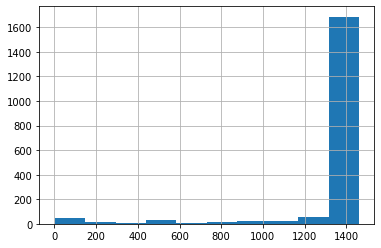

In [13]:
print(f"# Unique stores: {data_df['STORE_IP_ID'].unique().shape[0]}") 
data_df['STORE_IP_ID'].value_counts().hist();

In [14]:
counts = data_df['STORE_IP_ID'].value_counts()
quantile_cuttoff = counts.quantile(.1)
print(quantile_cuttoff)
stores_to_drop = counts[counts < quantile_cuttoff].index.tolist()
print(f'Stores to drop: {len(stores_to_drop)} out of {counts.shape[0]}')

1233.9
Stores to drop: 191 out of 1908


In [15]:
print(f'Data shape before: {data_df.shape[0]:,}')
data_df = data_df[~data_df['STORE_IP_ID'].isin(stores_to_drop)]
print(f'Data shape after drop low data stores: {data_df.shape[0]:,}')

Data shape before: 2,605,515
Data shape after drop low data stores: 2,485,627


## Some visualizations

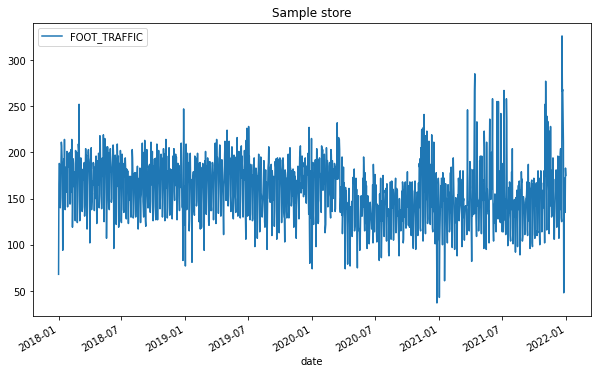

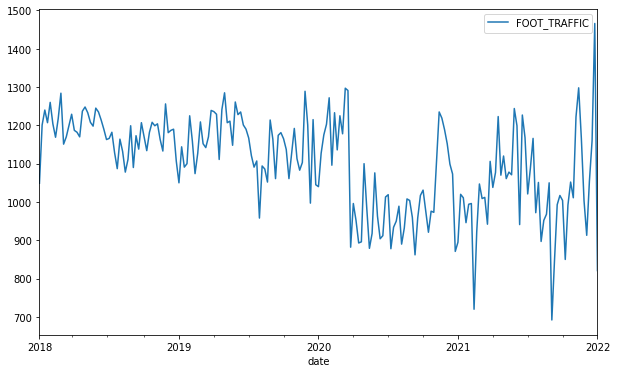

In [16]:
tmp = data_df[data_df['STORE_IP_ID'] == 68002].set_index('date')
tmp[['FOOT_TRAFFIC']].plot(figsize=[10,6], title='Sample store');
tmp.resample('W').sum()[['FOOT_TRAFFIC']].plot(figsize=[10,6]);


In [17]:
data_df.columns

Index(['date', 'STORE_IP_ID', 'FOOT_TRAFFIC', 'DB_TRAFFIC', 'HT_TRAFFIC',
       'DL_TRAFFIC', 'AGE_UNDER_18_TRAFFIC', 'AGE_18_TO_24_TRAFFIC',
       'AGE_25_TO_44_TRAFFIC', 'AGE_45_TO_64_TRAFFIC', 'AGE_65_PLUS_TRAFFIC',
       'ENTERPRISE_CD', 'CITY', 'PROV_CD'],
      dtype='object')

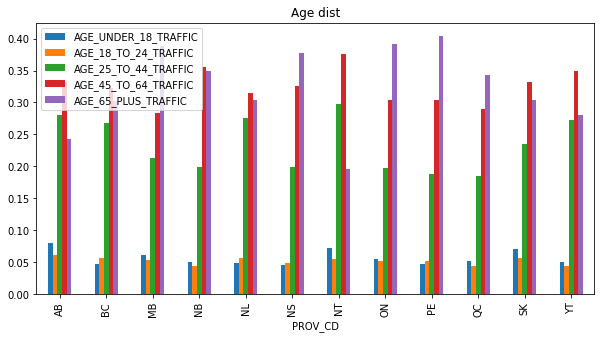

In [18]:
# Age distribution
ages = ['AGE_UNDER_18_TRAFFIC', 'AGE_18_TO_24_TRAFFIC',
       'AGE_25_TO_44_TRAFFIC', 'AGE_45_TO_64_TRAFFIC', 'AGE_65_PLUS_TRAFFIC']
tmp = data_df.groupby(['PROV_CD']).sum()[['FOOT_TRAFFIC'] + ages] 
for age in ages:
    tmp[age] = tmp[age] / tmp['FOOT_TRAFFIC']


tmp.drop(columns=['FOOT_TRAFFIC'], inplace=True)
tmp.plot.bar(figsize=[10,5], title='Age dist');

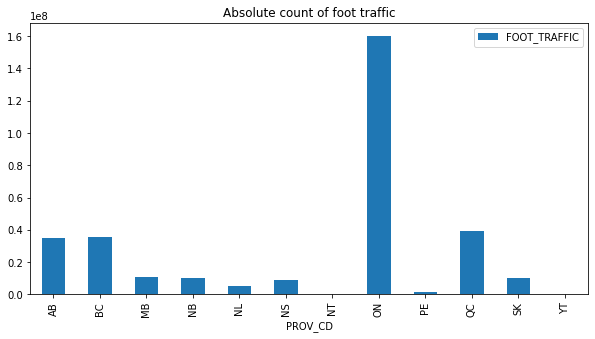

In [19]:
# all traffic counts
tmp = data_df.groupby(['PROV_CD']).sum()[['FOOT_TRAFFIC']] 
tmp.plot.bar(figsize=[10,5], title='Absolute count of foot traffic');

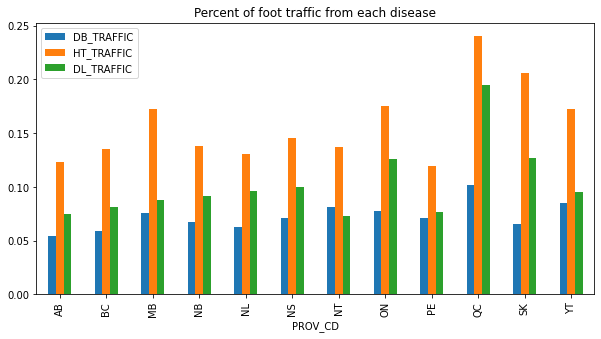

In [20]:
# # percent DB, HT, and DL in each prov
tmp = data_df.groupby(['PROV_CD']).sum()[['FOOT_TRAFFIC', 'DB_TRAFFIC', 'HT_TRAFFIC', 'DL_TRAFFIC']] 
tmp['DB_TRAFFIC'] = tmp['DB_TRAFFIC'] / tmp['FOOT_TRAFFIC']
tmp['HT_TRAFFIC'] = tmp['HT_TRAFFIC'] / tmp['FOOT_TRAFFIC']
tmp['DL_TRAFFIC'] = tmp['DL_TRAFFIC'] / tmp['FOOT_TRAFFIC']

tmp.drop(columns=['FOOT_TRAFFIC'], inplace=True)
tmp.plot.bar(figsize=[10,5], title='Percent of foot traffic from each disease');

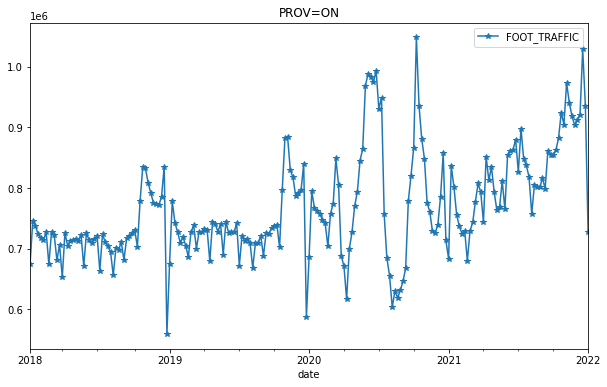

In [21]:
tmp = data_df[data_df['PROV_CD'] == 'ON']
tmp['date'] = pd.to_datetime(tmp['date'])
tmp = tmp.set_index('date')
tmp.resample('W').sum()[['FOOT_TRAFFIC']].plot(figsize=[10,6], title='PROV=ON', style='-*');

In [22]:
# data_filename = "/content/drive/MyDrive/bootcamp_datasets/boc_exchange/dataset.csv"
# data_filename = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/cpi_forecasting/all_data.csv"
# data_filename = "gs://hdps-rd-001/timeseries_vector/cpi_forecasting/all_data.csv"


# data_df = pd.read_csv(data_filename, index_col=0)
# data_df.index = pd.to_datetime(data_df.index)
# data_df = data_df.reset_index().rename({'index':'date'}, axis=1)
# data_df

## chose data slice

In [23]:
data_slice = data_df[data_df['PROV_CD'] == 'ON'].set_index('date')
data_slice = data_slice.resample('D').sum().reset_index()
data_slice['date'] = data_slice['date'].dt.date
data_slice.drop(columns=['STORE_IP_ID'], inplace=True)
print(f'NaN count: {data_slice.isna().sum().sum()}')
data_slice.head()

NaN count: 0


,date,FOOT_TRAFFIC,DB_TRAFFIC,HT_TRAFFIC,DL_TRAFFIC,AGE_UNDER_18_TRAFFIC,AGE_18_TO_24_TRAFFIC,AGE_25_TO_44_TRAFFIC,AGE_45_TO_64_TRAFFIC,AGE_65_PLUS_TRAFFIC
0,2018-01-01,33797,2765,6743,4924,2343,1804,6378,9027,14222
1,2018-01-02,146820,11407,27308,19658,8975,8222,25566,42798,61058
2,2018-01-03,130619,9704,23834,16933,7645,7166,23826,38010,53824
3,2018-01-04,125187,8574,20748,14469,7742,7195,23312,37723,49055
4,2018-01-05,108235,7175,17193,12047,6901,6302,21130,32887,40855


## Data Splitting

We immediately split the data into training and test sets. We can later split the training set into training and validation.

In [24]:
train_size = 0.8

train_df = data_slice.iloc[:int(len(data_slice)*train_size)]
test_df = data_slice.iloc[int(len(data_slice)*train_size):]

## Data Formatting

PyTorch Forecasting expects data to be formatted using its own [TimeSeriesDataSet](https://pytorch-forecasting.readthedocs.io/en/latest/data.html) objects. Building a TimeSeriesDataSet begins with a Pandas DataFrame, and like with Prophet and NeuralProphet, we need to add certain custom columns.

For this demo, we are once again specifying a lead time of 30 days and we will withhold the last 20% of data for testing. In the code below, we are very careful to ensure that when training and validating the model, it does not have access to the withheld data.

## Time Series Data Formatting

PyTorch Forecasting models can accomodate datasets consisting of multiple, coincident time series in several ways. As per the [documentation](https://pytorch-forecasting.readthedocs.io/en/latest/data.html), a combination of `group_id` and `time_idx` identify a sample in the data, and that *if we have only one time series, to set* `group_id` *to a constant.*

`time_idx` is an *integer column denoting the time index*. This, as opposed to the `date` column, is used to determine the temporal sequence of samples. 

In [25]:
lag_time =  2*1 #5*12
lead_time = 30   #12
train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
test_df['group_ids'] = 0

In [26]:
train_df.head()

,time_idx,date,FOOT_TRAFFIC,DB_TRAFFIC,HT_TRAFFIC,DL_TRAFFIC,AGE_UNDER_18_TRAFFIC,AGE_18_TO_24_TRAFFIC,AGE_25_TO_44_TRAFFIC,AGE_45_TO_64_TRAFFIC,AGE_65_PLUS_TRAFFIC,group_ids
0,0,2018-01-01,33797,2765,6743,4924,2343,1804,6378,9027,14222,0
1,1,2018-01-02,146820,11407,27308,19658,8975,8222,25566,42798,61058,0
2,2,2018-01-03,130619,9704,23834,16933,7645,7166,23826,38010,53824,0
3,3,2018-01-04,125187,8574,20748,14469,7742,7195,23312,37723,49055,0
4,4,2018-01-05,108235,7175,17193,12047,6901,6302,21130,32887,40855,0


In [27]:
train_df.shape, test_df.shape

((1168, 12), (293, 12))

## Preparing a TimeSeriesDataSet for N-BEATS

N-BEATS is a univariate forecasting method. As such, it can only process one variable at a time.

In [28]:
train_df_nbeats = train_df.melt(id_vars=['time_idx', 'date'], value_vars=data_slice.columns, var_name='group_ids')
# train_df_nbeats = train_df.melt(id_vars=['time_idx', 'date'], value_vars=target_cols, var_name='group_ids')

train_df_nbeats['group_ids'] = train_df_nbeats['group_ids'].astype(str)
train_df_nbeats.head()

,time_idx,date,group_ids,value
0,0,2018-01-01,FOOT_TRAFFIC,33797
1,1,2018-01-02,FOOT_TRAFFIC,146820
2,2,2018-01-03,FOOT_TRAFFIC,130619
3,3,2018-01-04,FOOT_TRAFFIC,125187
4,4,2018-01-05,FOOT_TRAFFIC,108235


In [29]:
train_df_nbeats.tail()

,time_idx,date,group_ids,value
10507,1163,2021-03-09,AGE_65_PLUS_TRAFFIC,52438
10508,1164,2021-03-10,AGE_65_PLUS_TRAFFIC,50419
10509,1165,2021-03-11,AGE_65_PLUS_TRAFFIC,49886
10510,1166,2021-03-12,AGE_65_PLUS_TRAFFIC,45963
10511,1167,2021-03-13,AGE_65_PLUS_TRAFFIC,25885


In [30]:
train_df_nbeats.group_ids.unique()

array(['FOOT_TRAFFIC', 'DB_TRAFFIC', 'HT_TRAFFIC', 'DL_TRAFFIC',
       'AGE_UNDER_18_TRAFFIC', 'AGE_18_TO_24_TRAFFIC',
       'AGE_25_TO_44_TRAFFIC', 'AGE_45_TO_64_TRAFFIC',
       'AGE_65_PLUS_TRAFFIC'], dtype=object)

In [31]:
train_df_nbeats.dtypes

time_idx      int64
date         object
group_ids    object
value         int64
dtype: object

The following code defines the training/validation split and important parts of the prediction task - the lag time and lead time. Here we are specifying that 25% of the training data should be used for validation. In total, this results in a 60/20/20 train/valid/test split (since 25% of 80% is 20% of the initial 100%).

In [32]:
# define dataset
valid_size = 0.25  
max_encoder_length = lag_time
max_prediction_length = lead_time
training_cutoff = train_df_nbeats["time_idx"][:int((1 - valid_size)*train_df_nbeats["time_idx"].max())].values[-1]
print(f'Training_cutoff: {training_cutoff}')
context_length = max_encoder_length
prediction_length = max_prediction_length

Training_cutoff: 874


Since NBEATS is actually a univariate forecasting model, it makes sense that pytorch-forecasting does not support specifying explanatory variables as `time_varying_unknown_reals`. Earlier, we used the Pandas function `melt` to reshape the data into a single `value` column that is uniquely indexed by pairs of `(time_idx, group_ids)`.

In [33]:
train_df_nbeats.loc[train_df_nbeats.time_idx <= training_cutoff]['group_ids'].unique()

array(['FOOT_TRAFFIC', 'DB_TRAFFIC', 'HT_TRAFFIC', 'DL_TRAFFIC',
       'AGE_UNDER_18_TRAFFIC', 'AGE_18_TO_24_TRAFFIC',
       'AGE_25_TO_44_TRAFFIC', 'AGE_45_TO_64_TRAFFIC',
       'AGE_65_PLUS_TRAFFIC'], dtype=object)

In [34]:
training = TimeSeriesDataSet(
    train_df_nbeats.loc[train_df_nbeats.time_idx <= training_cutoff],  # Applying the training cutoff
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder(add_nan=True).fit(train_df_nbeats.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"],
)

In [116]:
validation = TimeSeriesDataSet.from_dataset(training, train_df_nbeats, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

KeyError: "Unknown category '7008' encountered. Set `add_nan=True` to allow unknown categories"

## Training the model

In our first effort to train the N-BEATS model, we adopt the default configuration suggested by the pytorch-forecasting [tutorials](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/ar.html).

In [18]:
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
epoch_callback = EpochCallback()

trainer = pl.Trainer(
    max_epochs=50,
    gpus=0, # 1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback, epoch_callback],
    limit_train_batches=1.0,
)

net = NBeats.from_dataset(
    training,
    learning_rate=1e-4,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    # widths=[16, 16],
    # backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/envs/timeseries/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.802     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


{'sanity_check_loss': 7.789648056030273}


Training: 0it [00:00, ?it/s]

## Testing the model


In [18]:
test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="Fruit, fruit preparations and nuts",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["Fruit, fruit preparations and nuts"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

In [19]:
len(test_dataset)

15

## Collect test set predictions

In [20]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)
print(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_model.predict(test_dataloader)

/scratch/ssd001/home/ethanj/forecasting-bootcamp/demos/lightning_logs/version_6613709/checkpoints/epoch=16-step=8193.ckpt


## Plot model forecasts at max lead time

Like in Demo 1, we are plotting the predictions at max lead time as well as one individual example forecast. Feel free to modify the `start` variable to plot different examples.

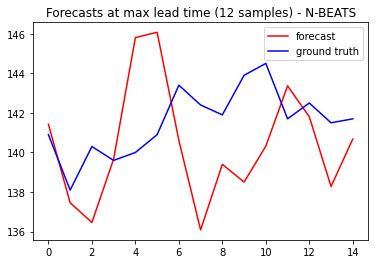

In [21]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

fig, ax = plt.subplots()
ax.plot(indexes, preds, color='red', label='forecast')
ax.plot(indexes, trues, color='blue', label='ground truth')
ax.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax.legend()

In [22]:
actuals_np.shape

(15, 12)

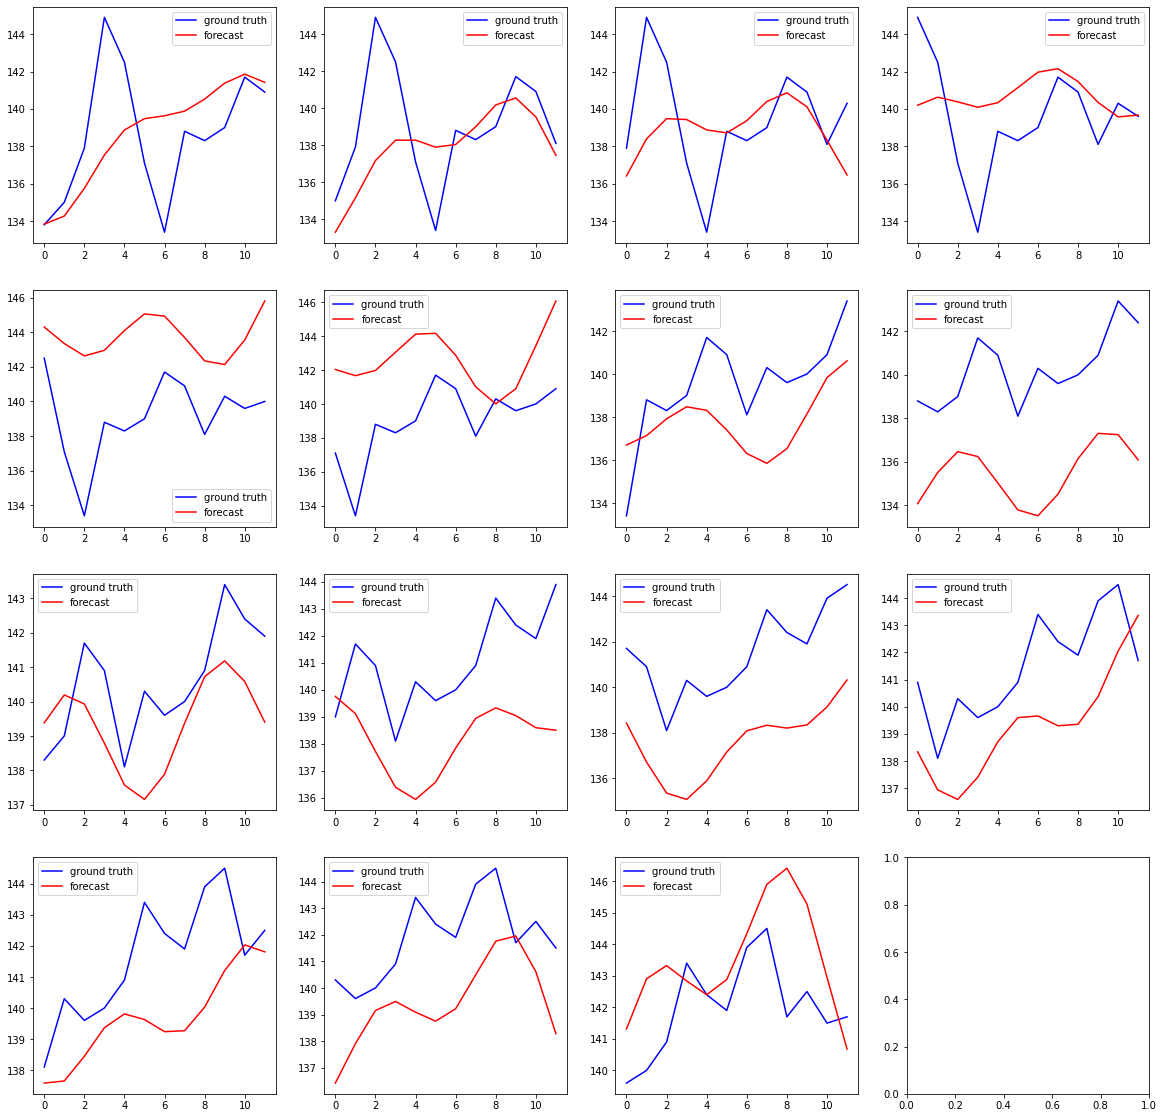

In [23]:
# plot at single time index

fig, axs = plt.subplots(4, 4, figsize=(20,20))
axs = axs.flatten()

for fig_index, example_index in enumerate(range(0, len(predictions_np), 1)):

    if fig_index > len(axs) - 1:
        break

    ground_truth = actuals_np[example_index]
    forecast = predictions_np[example_index]

    axs[fig_index].plot(list(range(0, len(forecast))), ground_truth, color='blue', label='ground truth')
    axs[fig_index].plot(list(range(0, len(forecast))), forecast, color='red', label='forecast')
    axs[fig_index].legend()

## Standard evaluation metrics


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

def compute_error_statistics(error_metrics_dict, exp_name):
    return {
        'mean': pd.DataFrame(error_metrics_dict).mean(axis=0).rename(f'{exp_name}_mean_metrics'),
        'std': pd.DataFrame(error_metrics_dict).std(axis=0).rename(f'{exp_name}_std_metrics'),
        'max': pd.DataFrame(error_metrics_dict).max(axis=0).rename(f'{exp_name}_max_metrics'),
    }

def compute_baseline_error_metrics(predictions, actuals):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(predictions)):
    
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=actuals[i], y_pred=predictions[i]))

    return errors

In [25]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

nbeats_errors = compute_baseline_error_metrics(predictions_np, actuals_np)
nbeats_stats = compute_error_statistics(nbeats_errors, 'nbeats')
nbeats_stats['mean']

mse     11.112105
rmse     3.202046
mae      2.781155
mape     0.019834
Name: nbeats_mean_metrics, dtype: float32